In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys, importlib, os

In [2]:
repo_paths = ['/home/simonealbanesi/repos/IPAM2021_ML/', '/home/simone/repos/IPAM2021_ML/']
for rp in repo_paths:
    if os.path.isdir(rp):
        repo_path = rp
        break
sys.path.insert(0, repo_path+'utils/')

In [3]:
import utils as ut
import classyNN as cnn
import errstats as es
import fancyplots as fp

In [4]:
hlayers_sizes   = (50,50)
seed            = 2
verbose_train   = False
epochs          = 100
batch_size      = 128

show_figs       = True
save_figs       = False

out_intervals = [[1,2], [1,2], [0.8,2]]

linear_output  = False # if True, out_intervals is ignored.
compact_scaler = False
std_scaler     = True
sigma0         = 10

## Load data 

In [5]:
data_path = repo_path+'datasets/GSTLAL_EarlyWarning_Dataset/Dataset/m1m2Mc/'
xtrain = cnn.extract_data(data_path+'xtrain.csv')
ytrain = cnn.extract_data(data_path+'ytrain.csv')
xtest  = cnn.extract_data(data_path+'xtest.csv')
ytest  = cnn.extract_data(data_path+'ytest.csv')

nfeatures = len(xtrain[0,:])
names   = ['m1', 'm2', 'Mc'];

--------------------------------------------------  train  -------------------------------------------------


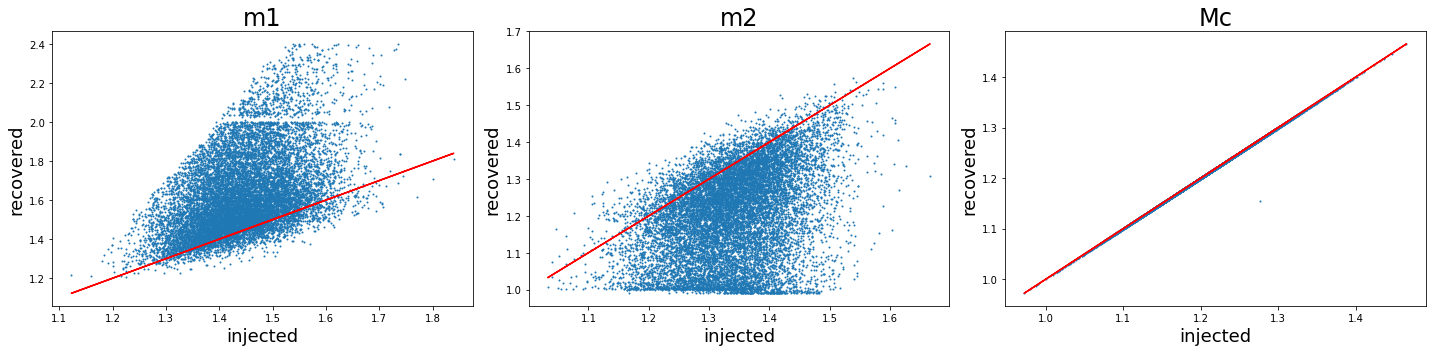

In [6]:
print('-'*50,' train ','-'*49)
plt.figure(figsize=(20,5))
for i in range(nfeatures):
    ax = plt.subplot(1,3,i+1)
    ax.scatter(ytrain[:,i], xtrain[:,i],s=1)
    ax.plot(ytrain[:,i], ytrain[:,i], 'r')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel('injected', fontsize=18)
    ax.set_ylabel('recovered', fontsize=18)
plt.tight_layout()
if save_figs:
    plt.savefig('rec_vs_inj.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

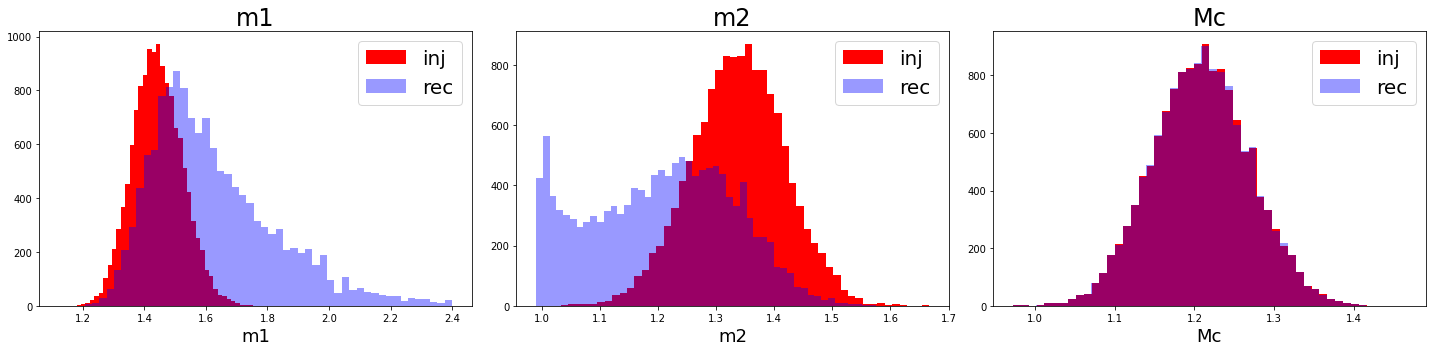

In [7]:
plt.figure(figsize=(20,5))
nbins = 30
for i in range(nfeatures):
    ax = plt.subplot(1,3,i+1)
    ax.hist(ytrain[:,i], bins=50, alpha=1,   color=[1,0,0], label='inj')
    ax.hist(xtrain[:,i], bins=50, alpha=0.4, color=[0,0,1], label='rec')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel(names[i], fontsize=18)
    ax.legend(fontsize=20)
plt.tight_layout()
if save_figs:
    plt.savefig('distr.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

## Train NN

In [8]:
NN = cnn.RegressionNN(nfeatures=nfeatures, hlayers_sizes=hlayers_sizes, out_intervals=out_intervals, 
                      seed=seed, linear_output=linear_output)
NN.print_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 50)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 2,903
Trainable params: 2,903
Non-trainable params: 0
_________________________________________________________________


In [9]:
NN.load_train_dataset(xtrain_data=xtrain, ytrain_data=ytrain, 
                      verbose=False, standard_scaler=std_scaler, sigma0=sigma0, compact_scaler=compact_scaler)

In [10]:
NN.training(epochs=epochs, batch_size=batch_size, verbose=verbose_train)

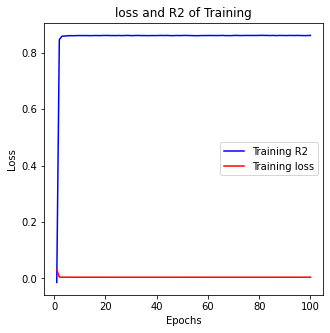

In [11]:
NN.plot_history(show=show_figs, save=save_figs)

## Check prediction

In [12]:
NN.load_test_dataset(xtest_data=xtest, ytest_data=ytest)
NN.print_metrics()

Final R2 mean  : 0.83658
R2[ 0]         : 0.72981
R2[ 1]         : 0.78006
R2[ 2]         : 0.99988


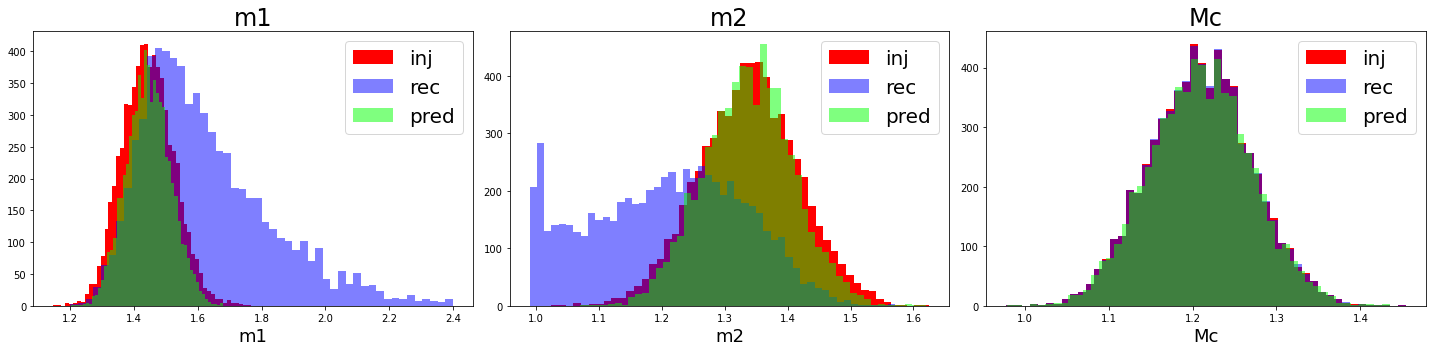

In [13]:
pred = NN.compute_prediction(NN.xtest, transform_output=True) # normalized prediction
plt.figure(figsize=(20,5))
nbins = 30
for i in range(nfeatures):
    ax = plt.subplot(1,3,i+1)
    ax.hist(ytest[:,i], bins=50, alpha=1,   color=[1,0,0], label='inj')
    ax.hist(xtest[:,i], bins=50, alpha=0.5, color=[0,0,1], label='rec')
    ax.hist( pred[:,i], bins=50, alpha=0.5, color=[0,1,0], label='pred')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel(names[i], fontsize=18)
    ax.legend(fontsize=20)
plt.tight_layout()
if save_figs:
    plt.savefig('distr_wpred.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

------------------------------------------------ m1 --------------------------------------------------
mean rec   rel diff  :  -0.12493 (std= 0.12255, | rel diff |= 0.13107)
mean pred  rel diff  :  -0.00191 (std= 0.02854, | rel diff |= 0.02317)


median rec   rel diff  :  -0.09535
median pred  rel diff  :  -0.00680


recovery   below fmin= -1.00: 0
recovery   above fmax=  1.00: 0
prediction below fmin= -1.00: 0
prediction above fmax=  1.00: 0


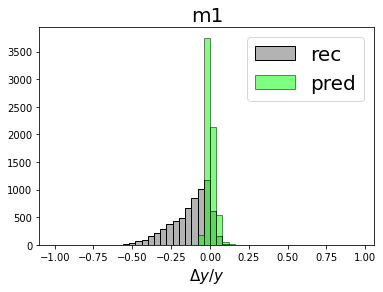

-----------------------------------------------  m2 --------------------------------------------------
mean rec  difference :   0.13106 (std= 0.11887, |difference|= 0.13904)
mean pred difference :   0.00066 (std= 0.03719, |difference|= 0.03001)


median rec  difference :   0.11284
median pred difference :   0.00715


recovery   below fmin= -1.00: 0
recovery   above fmax=  1.00: 0
prediction below fmin= -1.00: 0
prediction above fmax=  1.00: 0


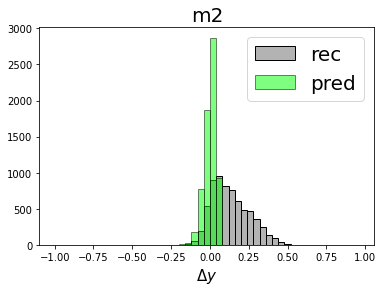

------------------------------------------------ Mc --------------------------------------------------
mean rec  difference :   0.00008 (std= 0.00015, |difference|= 0.00010)
mean pred difference :  -0.00014 (std= 0.00066, |difference|= 0.00050)


median rec  difference :   0.00004
median pred difference :  -0.00015


recovery   below fmin= -0.01: 0
recovery   above fmax=  0.01: 0
prediction below fmin= -0.01: 0
prediction above fmax=  0.01: 1


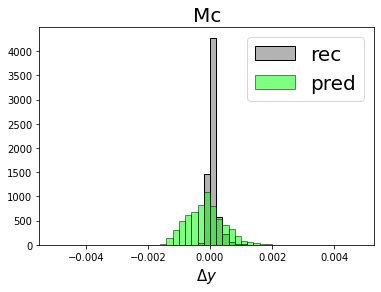

In [14]:
nolatex_names = [ 'm1',   ' m2',    'Mc' ]
fmin_vec      = [   -1,     -1 ,   -0.005]
fmax_vec      = [    1,      1 ,    0.005]
abs_diff_vec  = [False,     True,    True]
logscale_vec  = [False,    False,   False]

for i in range(nfeatures):
    print('-'*(50-len(nolatex_names[i])), nolatex_names[i], '-'*50)
    NN.plot_err_histogram(feature_idx=i, fmin=fmin_vec[i], fmax=fmax_vec[i], verbose=True, 
                          abs_diff=abs_diff_vec[i], name=names[i], show=show_figs, save=save_figs, 
                          logscale=logscale_vec[i], nbins=50)

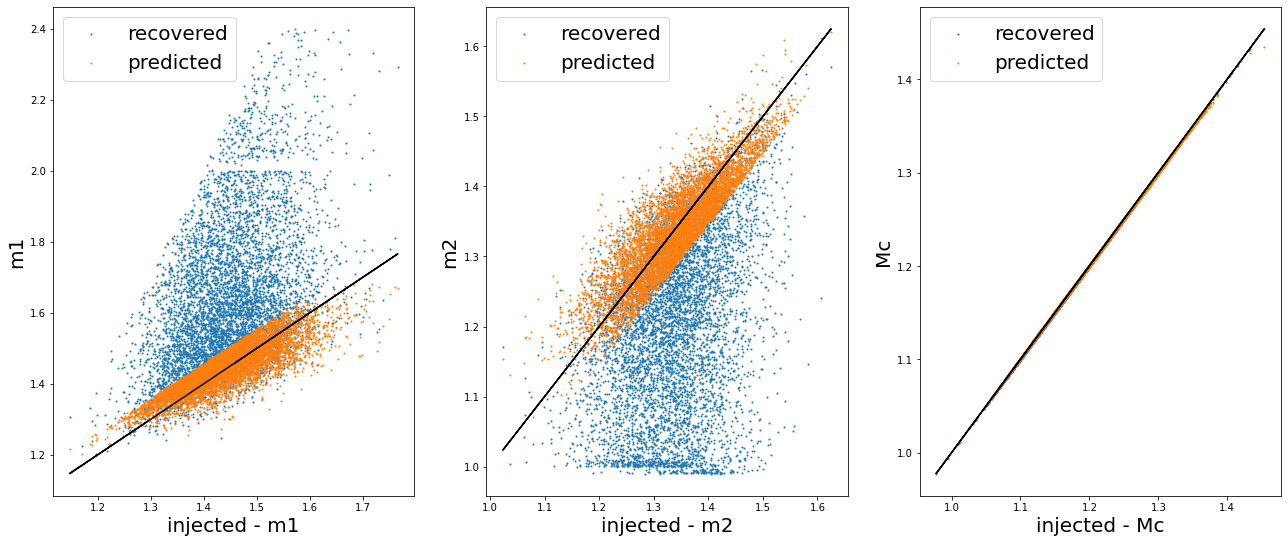

In [15]:
prediction = NN.compute_prediction(NN.xtest) # normalized prediction
fp.checkRegressionPlot(NN.xtest, NN.ytest, prediction, names, 
                              scaler_y=NN.scaler_y, scaler_x=NN.scaler_x, show=show_figs, save=save_figs)

## Error stats

In [16]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [17]:
predicted = NN.compute_prediction(NN.xtrain, transform_output=True)
injected  = NN.ytrain_notnorm
recovered = NN.xtrain_notnorm

####################################################################################################
features n.0: m1
####################################################################################################
----------------------------------------------------------------------------------------------------
dset: recovered
----------------------------------------------------------------------------------------------------



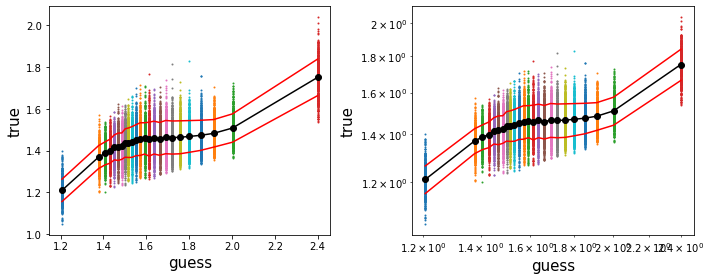

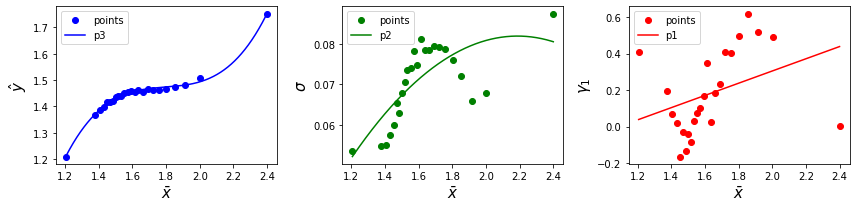

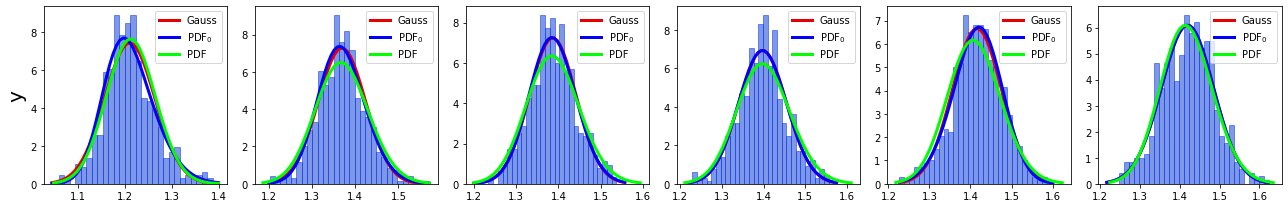

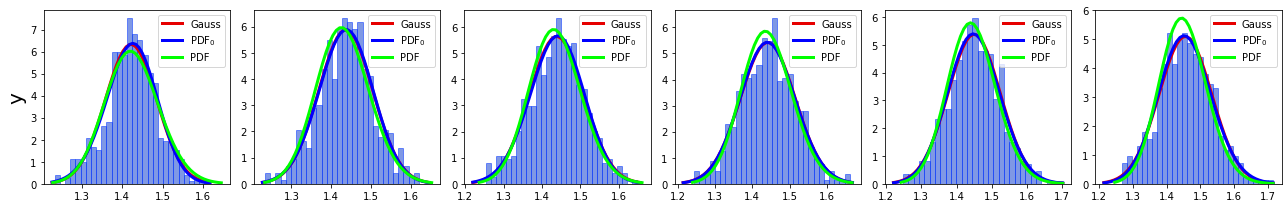

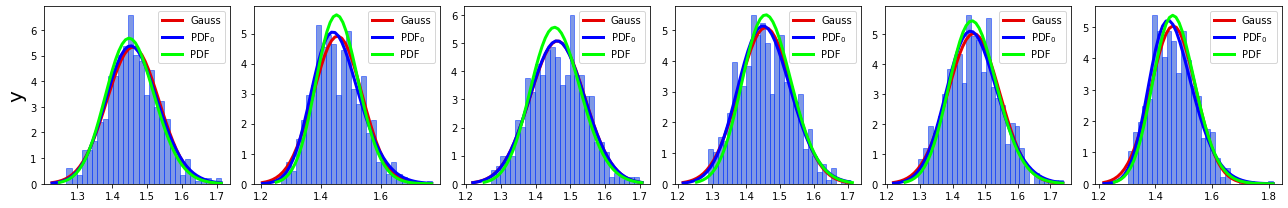

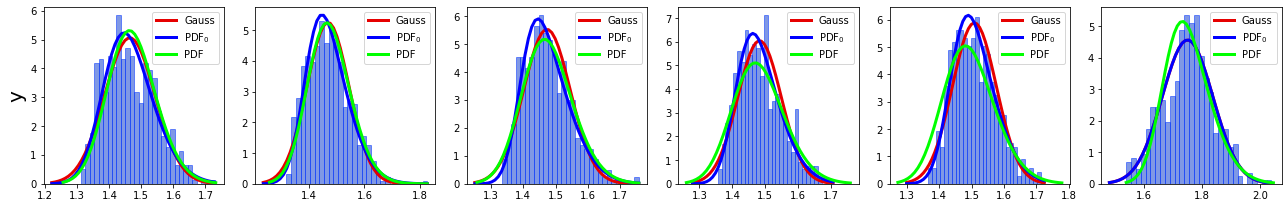

----------------------------------------------------------------------------------------------------
dset: predicted
----------------------------------------------------------------------------------------------------



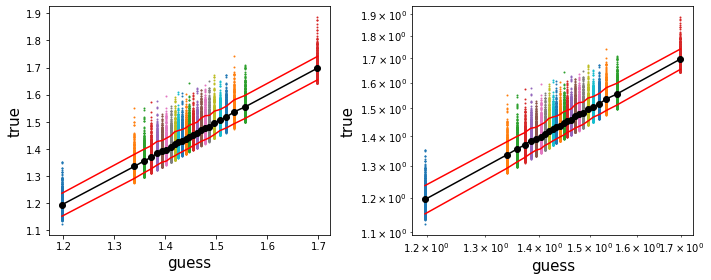

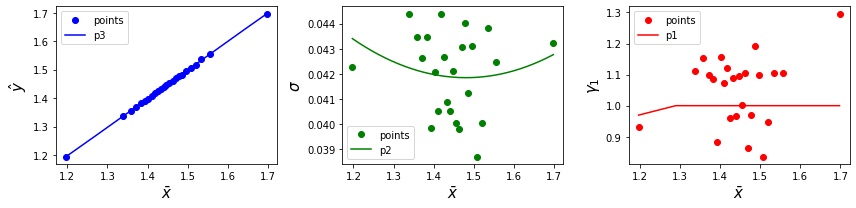

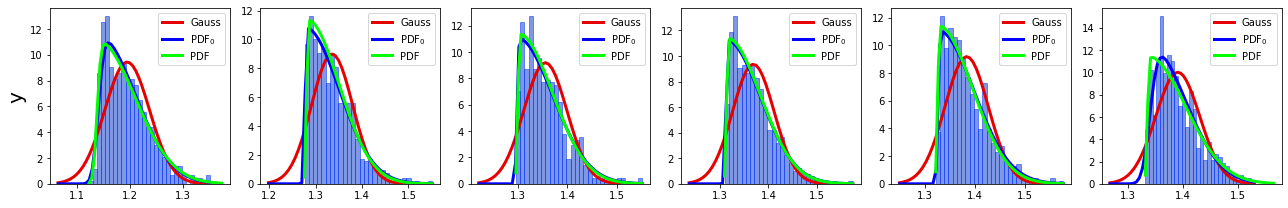

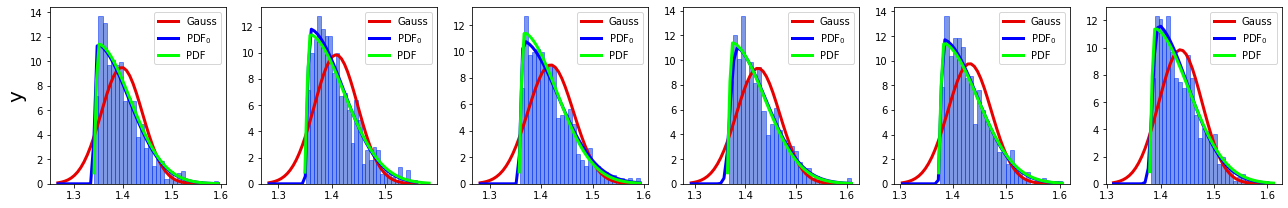

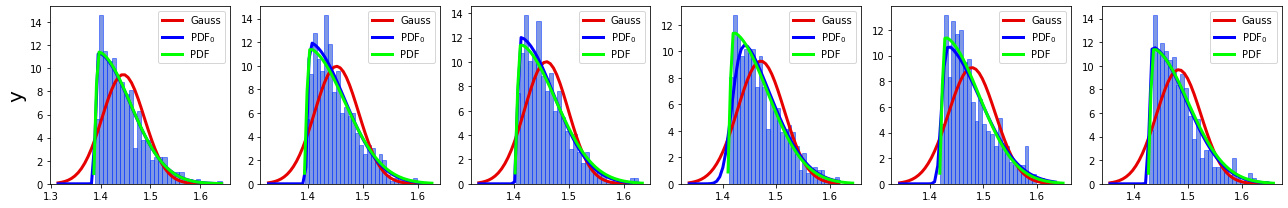

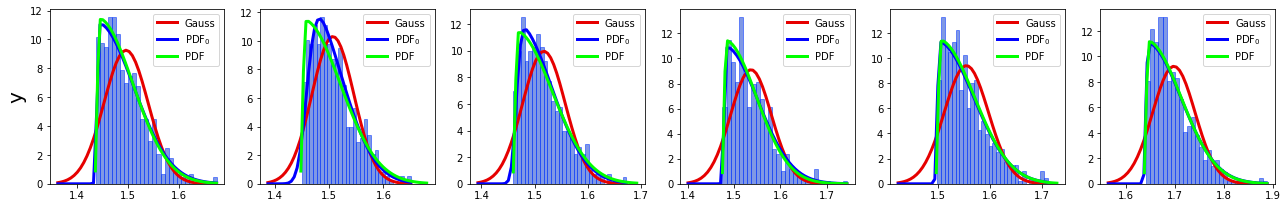

####################################################################################################
features n.1: m2
####################################################################################################
----------------------------------------------------------------------------------------------------
dset: recovered
----------------------------------------------------------------------------------------------------



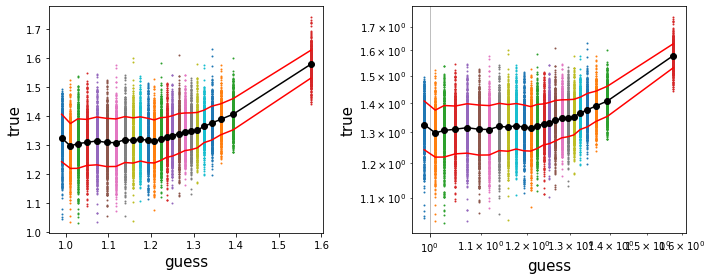

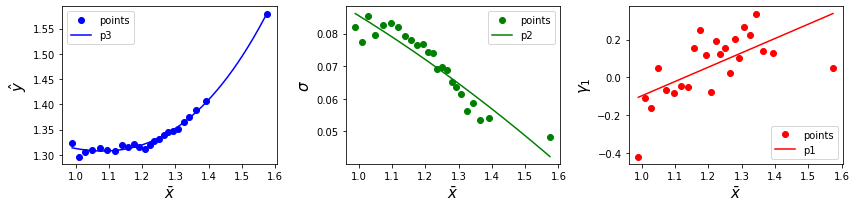

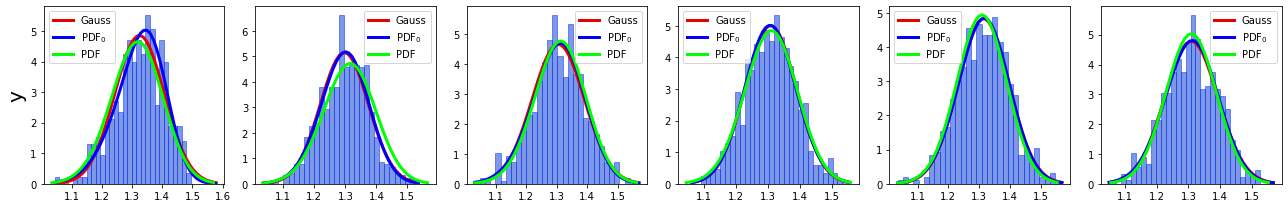

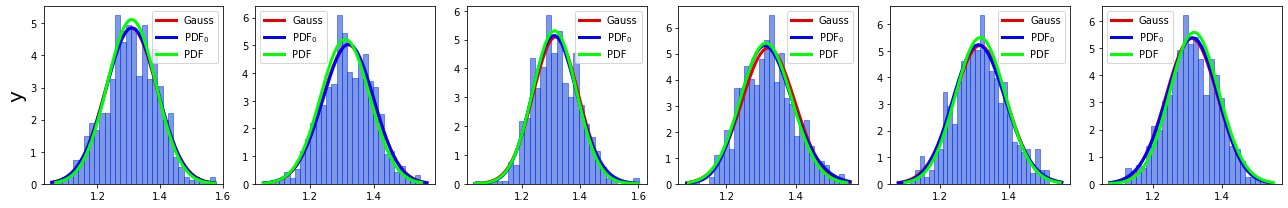

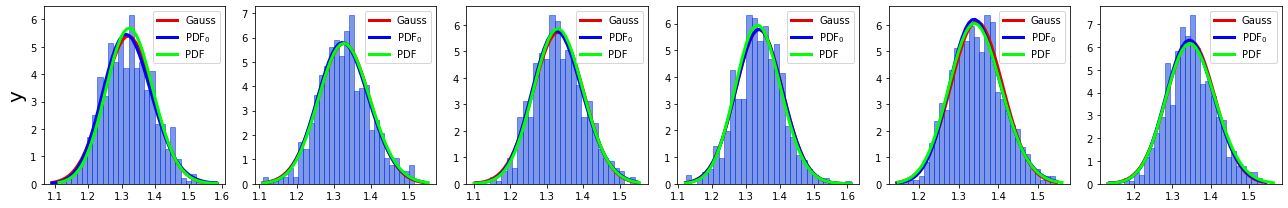

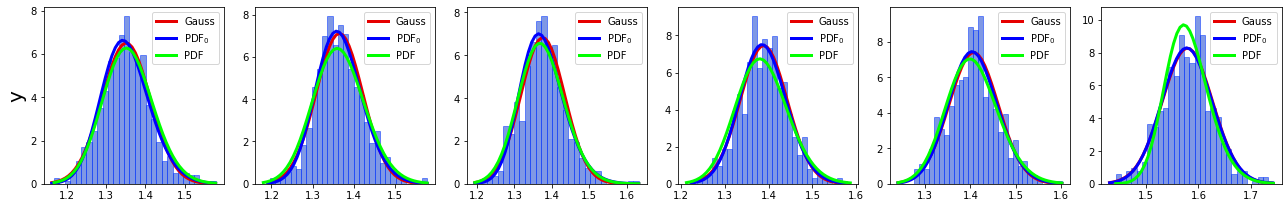

----------------------------------------------------------------------------------------------------
dset: predicted
----------------------------------------------------------------------------------------------------



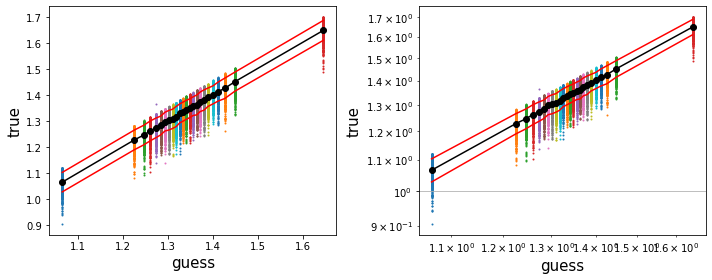

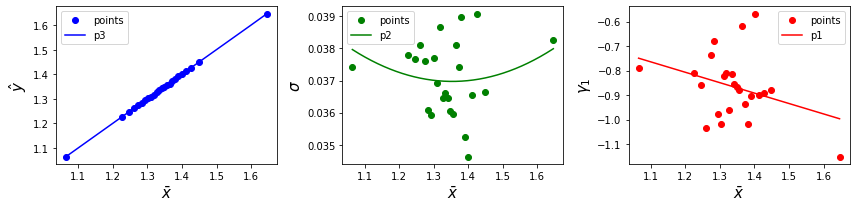

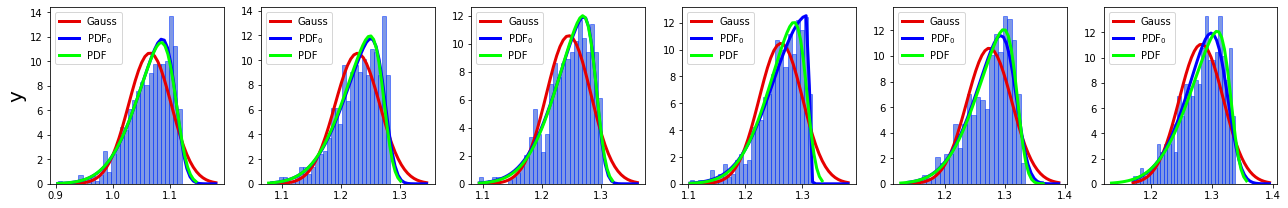

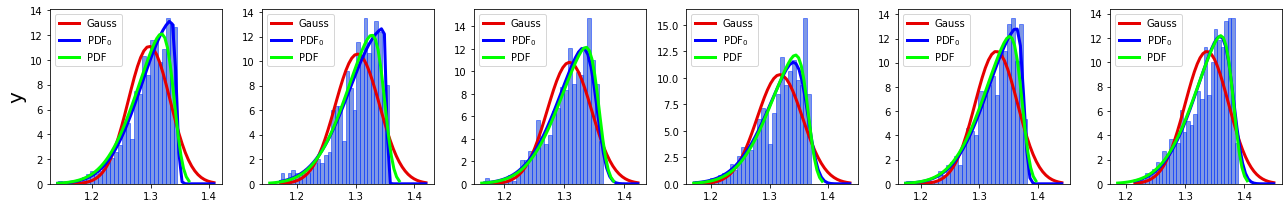

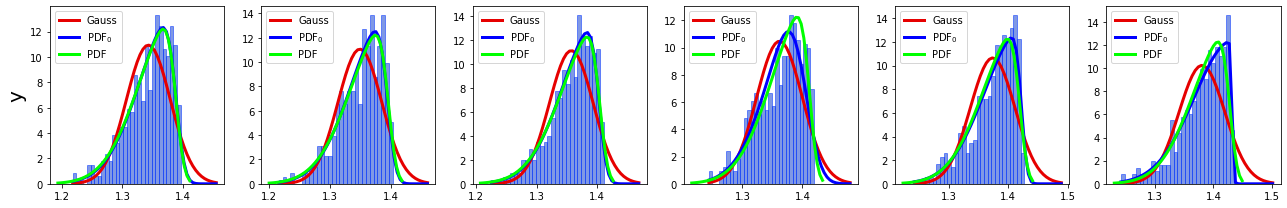

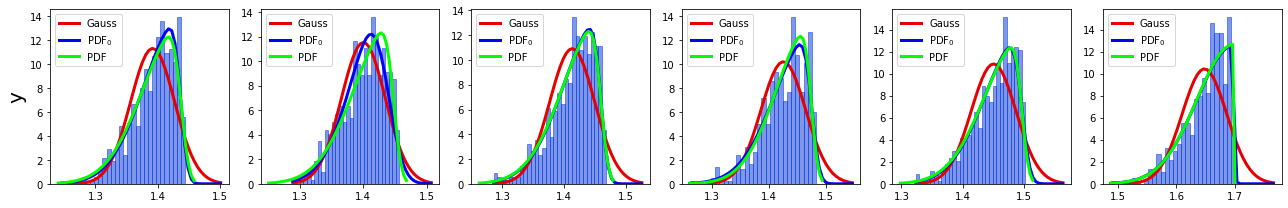

####################################################################################################
features n.2: Mc
####################################################################################################
----------------------------------------------------------------------------------------------------
dset: recovered
----------------------------------------------------------------------------------------------------



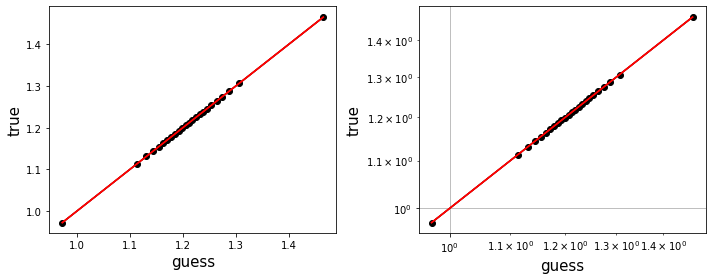

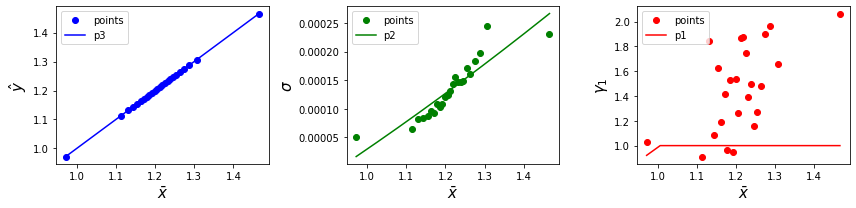

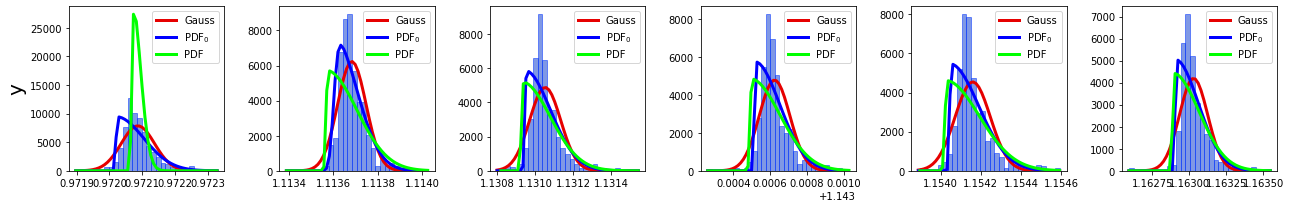

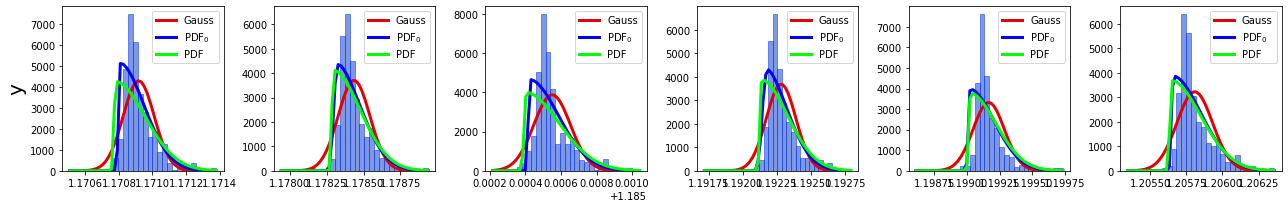

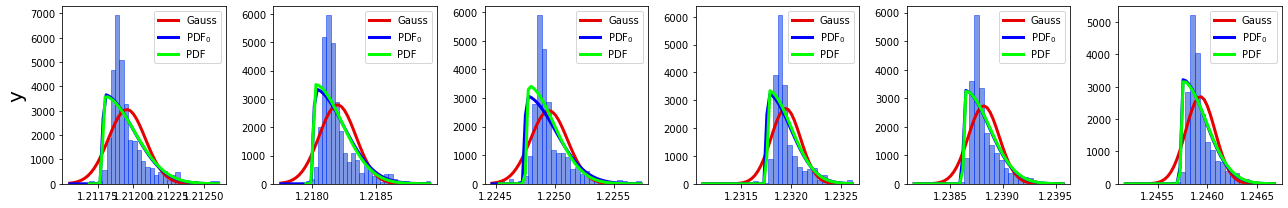

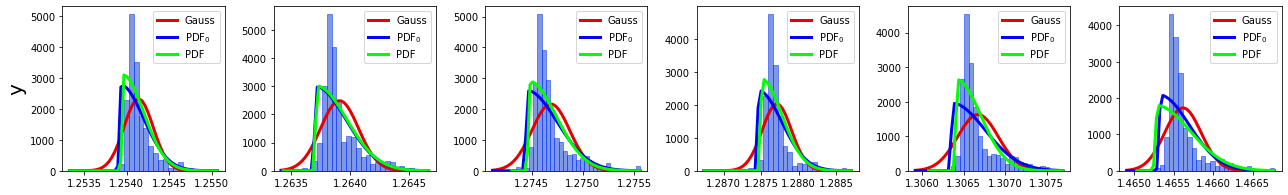

----------------------------------------------------------------------------------------------------
dset: predicted
----------------------------------------------------------------------------------------------------



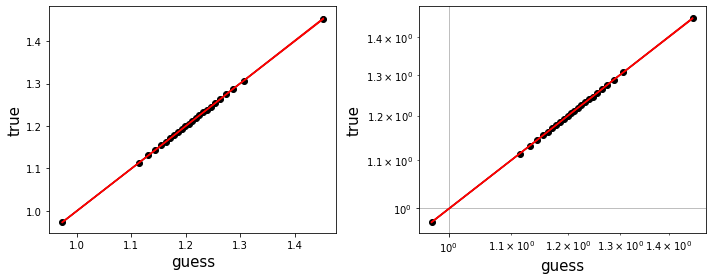

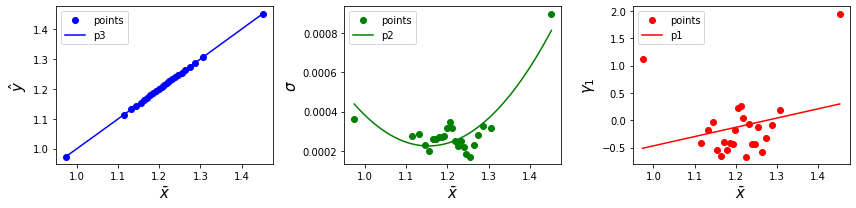

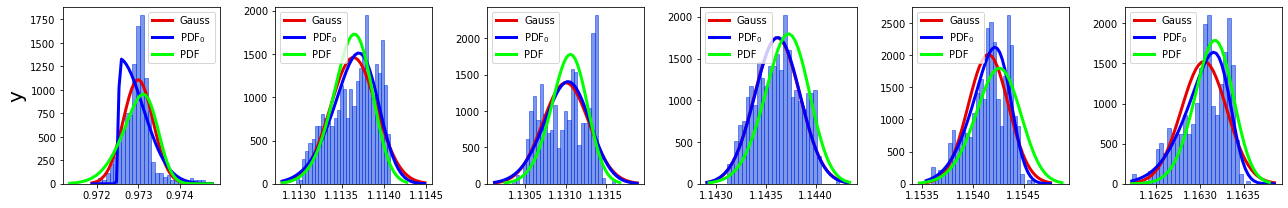

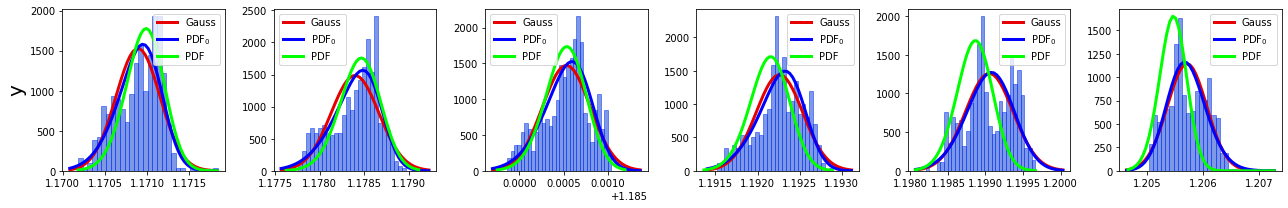

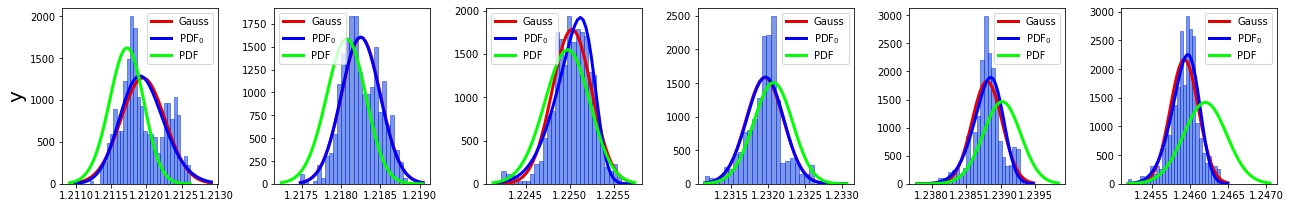

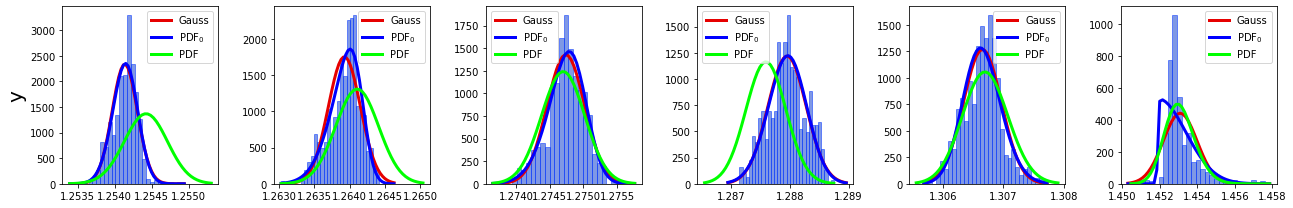

In [18]:
importlib.reload(es)

X = [recovered, predicted]
dsets = ['recovered', 'predicted']

for i in range(nfeatures):
    print('#'*100, '\nfeatures n.', i, ': ', names[i], '\n', '#'*100, sep='')
    for x, dset in zip(X, dsets):
        print('-'*100, '\ndset: ', dset, '\n', '-'*100, sep='', end='\n\n')
        ErrorStats = es.ErrorStats(verbose=False)
        ErrorStats.fit(x[:,i],injected[:,i], n=565, project=True, sigma=5, shift_extrema=True, npoly=[3,2,1]) 
        ErrorStats.plot_bins()
        #ErrorStats.plot_xstep()
        ErrorStats.plot_moments(plot_poly_fit=True)
        ErrorStats.plot_stats(plot_xbins=False, show_info=False, plot_exact_distr=True, 
                              plot_distr=True, show_gauss=True)

In [19]:
"""
# test save/load methods

importlib.reload(es)

ErrorStats = es.ErrorStats(verbose=True)
ErrorStats.fit(predicted[:,0],injected[:,0], n=565, project=True, sigma=5, shift_extrema=True, npoly=[3,2,1])
ErrorStats.plot_moments(plot_poly_fit=True)
ErrorStats.save('err_model.dill', verbose=True)

ErrorStats2 = es.ErrorStats(verbose=False)
ErrorStats2.load('err_model.dill', verbose=True)
ErrorStats.plot_moments(plot_poly_fit=True)
""";

## Example of complete pipeline

In [20]:
importlib.reload(es)
# 1) train the ML model
# ...

# 2) fit error-model for each feature
train_rec  = NN.xtrain_notnorm
train_inj  = NN.ytrain_notnorm
train_pred = NN.compute_prediction(train_rec, transform_input=True, transform_output=True)
ES_rec  = []
ES_pred = []
for i in range(nfeatures):
    esrec  = es.ErrorStats()
    esrec.fit(train_rec[:,i],   train_inj[:,i], n=565, project=True, sigma=5, shift_extrema=True, npoly=[3,2,1])
    ES_rec.append(esrec)
    espred = es.ErrorStats()
    espred.fit(train_pred[:,i], train_inj[:,i], n=565, project=True, sigma=5, shift_extrema=True, npoly=[3,2,1])
    ES_pred.append(espred)

# obtain prediction of the test dataset
recovered  = NN.xtest_notnorm
injected   = NN.ytest_notnorm
prediction = NN.compute_prediction(recovered, transform_input=True, transform_output=True)

# Is the prediction of the NN our final prediction? Seems not

In [21]:
idx       = 123
conf      = 0.95
show_plot = False

# WARNING: this is inconsistent! The procedure has to be fixed in some way 
# (e.g. kidnaping someone that knows statistics and make him/her work on this)

rec  =  recovered[idx,:]
inj  =   injected[idx,:]
pred = prediction[idx,:]

names = ['m1', 'm2', 'Mc']
for i in range(nfeatures):
    print('-'*30, '\n',' '*14, names[i], '\n', '-'*30, sep='')
    print('inj  : {:.5f}'.format(inj[i]) )
    x1, x2, ymean = ES_rec[i].confidence_interval(rec[i], conf, verbose=False, plot=show_plot);
    print('rec  : {:.5f} -{:.5f} +{:.5f}   ({:.5f}, {:.5f})   ymean:{:.5f}'.format(rec[i], abs(x1), x2, 
                                                                                   rec[i]+x1, rec[i]+x2, ymean))
    x1, x2, ymean = ES_pred[i].confidence_interval(pred[i], conf, verbose=False, plot=show_plot);
    print('pred : {:.5f} -{:.5f} +{:.5f}   ({:.5f}, {:.5f})   ymean:{:.5f}'.format(pred[i], abs(x1), x2, 
                                                                                   pred[i]+x1, pred[i]+x2, ymean))
    print('\n')

------------------------------
              m1
------------------------------
inj  : 1.41280
rec  : 1.53990 -0.13039 +0.14034   (1.40951, 1.68024)   ymean:1.44205
pred : 1.45187 -0.05347 +0.10018   (1.39840, 1.55205)   ymean:1.45042


------------------------------
              m2
------------------------------
inj  : 1.38476
rec  : 1.27276 -0.12750 +0.13445   (1.14526, 1.40721)   ymean:1.34136
pred : 1.34937 -0.08688 +0.05318   (1.26249, 1.40255)   ymean:1.35003


------------------------------
              Mc
------------------------------
inj  : 1.21763
rec  : 1.21764 -0.00017 +0.00032   (1.21747, 1.21797)   ymean:1.21773
pred : 1.21744 -0.00051 +0.00048   (1.21693, 1.21792)   ymean:1.21733


